In [1]:
import tessbatman as tb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Configure Batman Parameter File
tmin, tmax, tstep = (-30, 30, 0.13889)  # time (x val of batman curves)
wmin, wmax, wnum, wlog = (-3.9, -2.5, 30, True)  # width of batman curves
suffix = "_test"  # suffix to append to all files
path = "/home/cjtu/projects/tess_batman/code/test/"

tb.make_batman_config(tmin, tmax, tstep, wmin, wmax, wnum, wlog, suffix, path)

# Test the config
import json
from pprint import pprint
with open(path+"batmanConfig_test.param") as f:
    d=json.load(f)
pprint(d)

Batman config written to /home/cjtu/projects/tess_batman/code/test/batmanConfig_test.param
{'curves_fname': '/home/cjtu/projects/tess_batman/code/test/batmanCurves_test.csv',
 'params_fname': '/home/cjtu/projects/tess_batman/code/test/batmanParams_test.csv',
 'tmax': 30,
 'tmin': -30,
 'tstep': 0.13889,
 'wlog': True,
 'wmax': -2.5,
 'wmin': -3.9,
 'wnum': 30}


In [3]:
np.logspace(-1,-1,1)

array([0.1])

In [4]:
# Make batman curves
paramfile = path+"batmanConfig_test.param"
bparams, bcurves = tb.make_batman(paramfile, path, norm=True, write=True)

Reading param file
Setting param ranges
Generating curves
Generated 1/30 curves in 0.009803533554077148 s
Generated 30/30 curves in 0.10782790184020996 s
Writing files
Wrote params to /home/cjtu/projects/tess_batman/code/test/batmanParams_test.csv
Wrote curves to /home/cjtu/projects/tess_batman/code/test/batmanCurves_test.csv
Wrote files in 0.0999300479888916 s


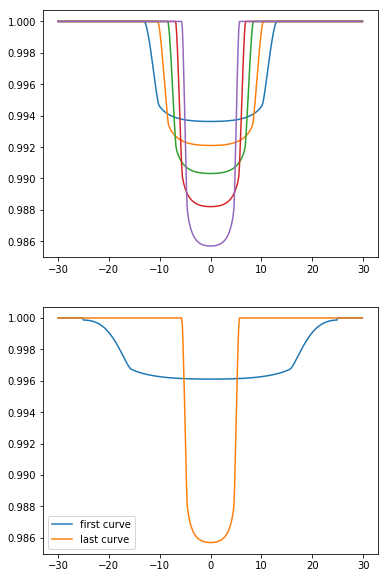

In [5]:
# A bunch of curves
f, axs = plt.subplots(2, figsize=(6,10))
for curveID in bcurves.colnames[10::5]:
    axs[0].plot(bcurves['times'], bcurves[curveID], label=curveID)
axs[1].plot(bcurves['times'], bcurves[bcurves.colnames[1]], label='first curve')
axs[1].plot(bcurves['times'], bcurves[bcurves.colnames[-1]], label='last curve')
plt.legend()

In [6]:
# pt = "/home/ctaiudovicic/projects/tess_batman/data/TESS/"
pt = "/common/contrib/classroom/ast520/tess_batman/sampleData/"
tstart = 2
tend = tstart+1
tess_names = tb.read_tess(pt, pt+"sample_Sector0", tstart, tend)
times, curve_names, batmanCurves = tb.read_batman(pt+"batmanCurves_test.csv")
tess_time, tess_flux = tb.open_tess_fits(tess_names[0], norm=True)
curves, times, convs = tb.convolve(tess_time, tess_flux, batmanCurves, curve_names, num_keep=len(curve_names))

# candidates for tstart to tend
candidates = tb.tbconvolve(pt, pb, suffix, 0, tstart, tend, pb, num_keep = -1, norm_tess=True, write=False)
# do all candidates and write to file
_ = tb.tbconvolve(pt, pb, suffix, 0, 0, 9, pb, num_keep = -1, norm_tess=True, write=True)

plt.plot(tess_time, tess_flux, 'bx')

Reading TESS from /common/contrib/classroom/ast520/tess_batman/sampleData/sample_Sector0, s:2, e:3...
Reading batmanCurves from /common/contrib/classroom/ast520/tess_batman/sampleData/batmanCurves_test.csv...


FileNotFoundError: [Errno 2] No such file or directory: '/common/contrib/classroom/ast520/tess_batman/sampleData/batmanCurves_test.csv'

In [ ]:
import matplotlib.colors as c
start = 10
step = 71

fig = plt.figure(figsize=(8, 4))
cm = c.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
# make colorbar
cmin = int(100*np.nanmin(candidates['correlation']))
cmax = int(100*np.nanmax(candidates['correlation']))
print(cmin, cmax)
if (cmax-cmin > 5):
    step = (cmax-cmin)//5
    if step < 1:
        step = 1
    Z = [[0,0],[0,0]]
    levels = range(cmin,cmax+step,step)
    CS3 = plt.contourf(Z, levels, cmap=cm)
    plt.clf()

    for i, curve in enumerate(bcurves.colnames[start::step]):#, len(candidates)):
        row = candidates[candidates['curveID'] == curve]
        r = (100*float(row['correlation'])-cmin)/(cmax-cmin)
        if r > 1:
            r = 1
        plt.plot(bcurves['times'], bcurves[curve], color=(r, 0, 1-r))
    plt.colorbar(CS3)

In [ ]:
best = candidates[np.argmax(candidates['correlation'])]
worst = candidates[np.argmin(candidates['correlation'])]
tess_curve = tess_names[0].split("/")[-1]

# Search for dip
ind = np.argmin(tess_flux[:15700])
# ind=6311
size = len(bcurves['times'])//2
s = ind-size
e = ind+size
mid = (e+s)//2

# Plot lightcurve, best and worst fits
f, axs = plt.subplots(2, figsize=(8,8))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.5)

# testcurve = 'curve59'
# axs[0].plot(tess_time[s:e], bcurves[testcurve], label=testcurve)

axs[0].plot(tess_time[s:e], tess_flux[s:e])

axs[1].plot(tess_time[s:e], bcurves[best['curveID']], label='best fit '+best['curveID'])
axs[1].plot(tess_time[s:e], bcurves[worst['curveID']], label='worst fit '+worst['curveID'])


axs[0].set_title("TESS lightcurve {}".format(tess_curve))
axs[1].set_title("Min lightcurve dip at t={:.3f}".format(tess_time[ind]))

axs[1].legend()

In [ ]:
# max convolutions of each curve
plt.plot(convs)

In [ ]:
# manual convolve and plots
from scipy.signal import fftconvolve
plot = True


cnames = np.append(curve_names[0::50], best['curveID'])
nplots = len(cnames)+1
fig, axs = plt.subplots(nplots,2, figsize=(11, nplots*2))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.5)
for i, curvename in enumerate(cnames):
    batman_curve = batmanCurves[curvename]
    conv = np.abs(fftconvolve(1-tess_flux, (1-batman_curve), 'same'))
    ind_max = np.argmax(conv)
    conv_max = conv[ind_max]
    
    print(curvename, tess_time[ind_max], conv_max)
    axs[i,0].plot(tess_time, conv, '+')
    axs[i,1].plot(tess_time[s:e], conv[s:e], '+')
    axs[i,0].set_title("Conv: {}".format(curvename))
    axs[i,1].set_title("max_conv={:.4f}".format(conv_max))

     
axs[-1,0].plot(tess_time, tess_flux, 'yx')
axs[-1,1].plot(tess_time[s:e], tess_flux[s:e], 'yx')
axs[-1,0].set_title("Light curve: {}".format(tess_names[0].split("/")[-1]))


fig2,axs2 = plt.subplots(3, figsize=(6,6))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.5)

axs2[0].set_title("TESS light curve: {}".format(tess_names[0].split("/")[-1]))
axs2[0].set_ylabel("relative flux")
axs2[0].plot(tess_time, tess_flux, 'x')
axs2[1].set_title("BATMAN transit curve: {}".format(best['curveID']))
axs2[1].set_ylabel("convolution signal")
axs2[1].plot(tess_time[s:e], bcurves[best['curveID']], label=best['curveID'])
axs2[2].set_title("Convolution (maximum: {:.3f})".format(conv_max))
axs2[2].set_ylabel("convolved flux")
axs2[2].plot(tess_time[conv>0.45], conv[conv>0.45], '+')
axs2[2].set_xlabel("time (days)")

In [ ]:
params_file = "batmanParams_test.csv"
candidates_file = "candidates_sector0_s0_e8.csv"
make_table(pt, params_file, candidates_file)

In [ ]:
import pandas as pd
chisq_file = "chisquared_values.csv"
chisq = pd.read_csv(chisq_file)

In [ ]:
chisq.sort_values('reducedChiSq').head(20)